# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 4: Convolutional Neural Networks


**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas


<hr style="height:2pt">

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS

- This homework can be submitted **in pairs**.

- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "Training and validation MSE at varying degree polynomial regression models" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

In [2]:
# These 3 installs are needed ONLY when using Colab.
# DO NOT RUN THESE ON JUPYTERHUB!!!

!pip install tensorflow_addons
!pip install tensorflow_datasets
!pip install tf_keras_vis

     |████████████████████████████████| 1.1 MB 20.4 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 


In [3]:
import os
import pathlib
import time
import zipfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm

%matplotlib inline

**Please run these cells below.** First we set our local working directory to ensure our provided code in PART 2 works correctly, and then we enable [TensorFlow eager execution](https://www.tensorflow.org/guide/eager) and print a summary of whether there are local GPUs available for training your models. Running this HW on JupyterHub is recommended. But as long as you are using the provided `cs109b.yml` conda environment, you should expect to see a TensorFlow version >=2.3.0, which should allow this notebook to run without error.

In [4]:
# RUN THIS CELL

working_dir = pathlib.Path().absolute()
# Uncomment line below to debug if images don't show
#print(working_dir)
os.chdir(working_dir)

In [5]:
# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



<a id="contents"></a>

## Notebook Contents

- [**PART 1 [55 pts]: Building a Basic CNN Model**](#part1)
  - [Overview](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**PART 2 [45 pts]: Regression with CNN**](#part2)
  - [Overview](#part2intro)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


## About this Homework

In this homework, we will explore Convolutional Neural Networks (CNNs).

- In [PART 1](#part1), we will begin by building a CNN to classify CIFAR-10 images, a standard pedagogical problem, and use saliency maps to understand where the network is placing its "attention."


- Then, in [PART 2](#part2), we will then see that CNNs are great for more than just classifying our images! They can serve as image input processing for a variety of tasks, as we will show by training a network on the CelebA dataset to rotate images of faces upright.

**IMPORTANT NOTES:**

- Convolutional neural networks are computationally intensive.
- **We highly recommend that you train your model on a system using GPUs. For this, we recommend using the GPU-enabled JupyterHub environment provided to you as part of this course** (or you could also take a look at Google Colab's runtime settings for accessing a GPU-enabled environment free of cost).
- Models that take hours to train on CPUs can be trained in just minutes when using GPUs.
- Additionally, **if you become frustrated having to rerun your model every time you open your notebook, take a look at how to save your trained model weights for later use** (as is required in [PART 2, question 2.2.3](#q223)).

**KERNEL CRASHES:**

If your kernel crashes as you attempt to train your model, please check the following items:
- Models with too many parameters might not fit in GPU memory. Try reducing the size of your model.
- A large `batch_size` will attempt to load too many images in GPU memory. Avoid using a very large batch size.
- Avoid creating multiple copies of the data.

<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [55 pts]: Building a Basic CNN Model

[Return to contents](#contents)


<a id="part1intro"></a>

## Overview

[Return to contents](#contents)

In this question, you will use Keras to create a convolutional neural network for predicting the "type of object" shown in each image from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset. This dataset contains 50,000 32x32 colored training images and 10,000 test images of the same size, with a total of 10 classes, representing the "type of object" shown in each image.

<a id="part1questions"></a>

### <div class='exercise'>PART 1: Questions</div> 

[Return to contents](#contents)

<a id="q11"></a>

**1.1** <span style='color:blue'>**Loading CIFAR-10 and Constructing the Model**</span>

<a id="q111"></a>

**1.1.1** Load the CIFAR-10 dataset from the `tensorflow.keras.datasets.cifar10` import shown at the top of this notebook. Perform any preprocessing of the data that might be required for this dataset.

<a id="q112"></a>

**1.1.2** Construct a classification model architecture using a combination of the following layers: Conv2D, MaxPooling2D, Dense, Dropout and Flatten. The layers don’t necessarily need to be in this order, and you can use as many of these types of layers as you’d like. 

  - You may use an existing architecture like AlexNet or VGG16, or create your own.

  - However, you MUST code the network yourself and not use a pre-written implementation. 

  - You must have at least 2 Conv2D layers, and at least one of your Conv2D layers should have 9 or more filters in order to complete question 1.4.1.


<a id="q12"></a>

**1.2** <span style='color:blue'>**Model parameter growth**</span>

How does the number of total parameters change (e.g. linearly, exponentially, etc.) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture and increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship. **HINT:** Completing this question is far easier if you write a function that generates your desired architecture in 1.1.2, with arguments that allow you to easily rebuild the architecture with varying numbers of filters per layer.

<a id="q13"></a>

**1.3** <span style='color:blue'>**Choose a model, train and evaluate it**</span>

<a id="q131"></a>

**1.3.1** Print the model summary for your chosen architecture, and report the total number of parameters. Then train your model using the CIFAR-10 dataset, and `validation_split=0.2`. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs. Your validation and test accuracies should both exceed 70%.

<a id="q132"></a> 

**1.3.2** Plot the training loss and accuracy per epoch (both train and validation) for your chosen architecture.
 

<a id="q14"></a> 

**1.4** <span style='color:blue'>**Techniques to visualize the model**</span>
 
We will gain an intuition into how our model is processing the inputs in two ways.  First we'll ask you to use activation maps to visualize the activations in the intermediate layers of the network. We've provided a helper function `get_activation_maps` to aid in extracting activation maps from layer outputs in your model network.  Feel free to take advantage of it if you'd like.  We'll also ask you to use [saliency maps](https://arxiv.org/abs/1312.6034) to visualize the pixels that have the largest impact on the classification of an input (image in this case), including a more recent development, a [Grad-CAM](https://arxiv.org/abs/1610.02391) saliency heatmap, which has been shown to better indicate the attention of CNNs.
 
<a id="q141"></a> 

**1.4.1** For a given input image from the test set that is correctly classified, use your model and extract 9 activation maps from an intermediate convolutional layer of your choice and plot the images in a 3x3 grid (use `imshow`'s `cmap='gray'` to show the activation maps in black & white).  Make sure to plot (and clearly label) your original input image as well. You may use the provided `get_activation_maps` function and the `cifar10dict` dictionary to convert class index to the correct class name.

<a id="q142"></a> 

**1.4.2** For the same input image generate and plot a SmoothGrad saliency map to show the pixels in the image most pertinent to classification, and a Grad-CAM saliency heatmap. This is most easily done with the [tf-keras-vis](https://pypi.org/project/tf-keras-vis/) package. Take a look at the "Usage" examples; it will be straightforward to apply to our model. Feel free to pick your own [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html); however, please stick to "perceptionally uniform sequential" or "sequential" colormaps because they are far easier to interpret (`jet` is neither). Arrange the three plots in a row using subplots: Original Image, SmoothGrad saliency Map, Grad-CAM saliency heatmap. Which visualization is easier to understand in your case, and what does the network seem to be focusing on?

<a id="q143"></a> 

**1.4.3** Repeat 1.4.2, but for an image from the test set that is **incorrectly classified**, indicating both the incorrect label and what the correct label should be, and from the visualizations of network attention, hypothesize why the network arrived at its answer. (Make sure you pass a new loss to the visualizers that uses the **incorrect** class index, because we want to see what caused the network to think the image was in that category!) If you had control over what images go in the training dataset, how could you modify it to avoid this particular network failure?

<a id="part1solutions"></a>

## PART 1: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**1.1**  <span style='color:blue'>**Loading CIFAR-10 and Constructing the Model**</span>

<a id="q111"></a>



</div>

<div class='exercise-r'>

**1.1.1**  Load the CIFAR-10 dataset from the `tensorflow.keras.datasets.cifar10` import shown at the top of this notebook. Perform any preprocessing of the data that might be required for this dataset.

<a id="q112"></a>



</div>

In [6]:
# your code here
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("x train dimensions: ", x_train.shape)
print("x pixel range: ", x_train.min(), "-", x_train.max())
print("y train dimensions: ", y_train.shape)

# normalize pixel values to 0-1
x_train = x_train/255
x_test = x_test/255

170508288/170498071 [==============================] - 2s 0us/step
x train dimensions:  (50000, 32, 32, 3)
x pixel range:  0 - 255
y train dimensions:  (50000, 1)


<div class='exercise-r'>

**1.1.2**  Construct a classification model architecture using a combination of the following layers: Conv2D, MaxPooling2D, Dense, Dropout and Flatten. The layers don’t necessarily need to be in this order, and you can use as many of these types of layers as you’d like. 

  - You may use an existing architecture like AlexNet or VGG16, or create your own.

  - However, you MUST code the network yourself and not use a pre-written implementation. 

  - You must have at least 2 Conv2D layers, and at least one of your Conv2D layers should have 9 or more filters in order to complete question 1.4.1.


<a id="q12"></a>



</div>

In [7]:
  filters_number = 8
  
  model = Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))
  model.add(Conv2D(filters_number, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(filters_number, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters_number*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(filters_number*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters_number*4, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(filters_number*4, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(filters_number*4, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))

  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 8)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 16)        2320      
                                                        

<div class='exercise-r'>

**1.2**  <span style='color:blue'>**Model parameter growth**</span>

How does the number of total parameters change (e.g. linearly, exponentially, etc.) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture and increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship. **HINT:** Completing this question is far easier if you write a function that generates your desired architecture in 1.1.2, with arguments that allow you to easily rebuild the architecture with varying numbers of filters per layer.

<a id="q13"></a>



</div>

In [8]:
# your code here

def number_params(filters_number):
  model = Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))
  model.add(Conv2D(filters_number, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(filters_number, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters_number*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(filters_number*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters_number*4, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(filters_number*4, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(filters_number*4, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))

  return model, model.count_params()

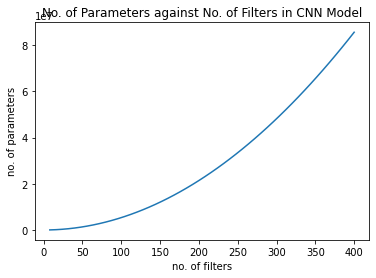

In [9]:
filters_ = range(8, 401, 8)
param = [number_params(i)[1] for i in filters_]

# plot
fig, ax = plt.subplots(1,1)
ax.plot(filters_,param)
ax.set_xlabel("no. of filters")
ax.set_ylabel("no. of parameters")
ax.set_title("No. of Parameters against No. of Filters in CNN Model")
plt.show()

**INTERPRETATION:**

* The number of parameters increases exponentially with the number of filters in the architecture.
* This is because the number of parameters in each convolutional layter is equal to the number of filters multiplied by the size of the filter.

<div class='exercise-r'>

**1.3**  <span style='color:blue'>**Choose a model, train and evaluate it**</span>

<a id="q131"></a>



</div>

<div class='exercise-r'>

**1.3.1**  Print the model summary for your chosen architecture, and report the total number of parameters. Then train your model using the CIFAR-10 dataset, and `validation_split=0.2`. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs. Your validation and test accuracies should both exceed 70%.

<a id="q132"></a> 



</div>

In [10]:
model, _ = number_params(32)

# print model summary
model.summary()

# compile and train
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              loss= 'sparse_categorical_crossentropy',metrics = ['accuracy'])

history = model.fit(x = x_train, 
                    y = y_train, 
                    epochs = 100, 
                    batch_size = 64, 
                    validation_split = 0.2,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_306 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_307 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_153 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_204 (Dropout)       (None, 16, 16, 32)        0         
                                                                 
 conv2d_308 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_309 (Conv2D)         (None, 16, 16, 64)        36928     
                                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
625/625 [==============================] - 16s 10ms/step - loss: 2.0738 - accuracy: 0.2274 - val_loss: 1.7930 - val_accuracy: 0.3448
Epoch 2/100
625/625 [==============================] - 5s 8ms/step - loss: 1.7352 - accuracy: 0.3558 - val_loss: 1.5983 - val_accuracy: 0.4125
Epoch 3/100
625/625 [==============================] - 6s 9ms/step - loss: 1.6126 - accuracy: 0.4045 - val_loss: 1.4918 - val_accuracy: 0.4548
Epoch 4/100
625/625 [==============================] - 5s 8ms/step - loss: 1.5131 - accuracy: 0.4435 - val_loss: 1.3959 - val_accuracy: 0.4982
Epoch 5/100
625/625 [==============================] - 5s 8ms/step - loss: 1.4322 - accuracy: 0.4791 - val_loss: 1.3896 - val_accuracy: 0.4960
Epoch 6/100
625/625 [==============================] - 5s 8ms/step - loss: 1.3667 - accuracy: 0.5041 - val_loss: 1.2718 - val_accuracy: 0.5571
Epoch 7/100
625/625 [==============================] - 5s 8ms/step - loss: 1.3123 - accuracy: 0.5254 - val_loss: 1.2530 - val_accuracy: 0.55

In [11]:
# test accuracy
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.5979 - accuracy: 0.8129


[0.5979458093643188, 0.8129000067710876]

<div class='exercise-r'>

**1.3.2**  Plot the training loss and accuracy per epoch (both train and validation) for your chosen architecture.
 

<a id="q14"></a> 



</div>

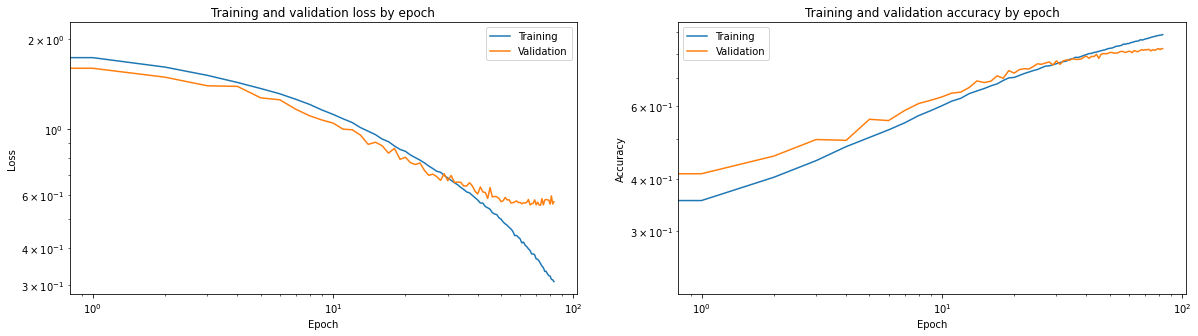

In [12]:
def plot_loss_acc(history):
    train_loss = history.history['loss'] 
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(1, 2, figsize = (20,5))
    ax[0].loglog(train_loss, label = 'Training')
    ax[0].loglog(val_loss, label = 'Validation')
    ax[0].set_title('Training and validation loss by epoch')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].loglog(train_acc, label = 'Training')
    ax[1].loglog(val_acc, label = 'Validation')
    ax[1].set_title('Training and validation accuracy by epoch')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.show()
    pass

plot_loss_acc(history)


<div class='exercise-r'>

**1.4**  <span style='color:blue'>**Techniques to visualize the model**</span>
 
We will gain an intuition into how our model is processing the inputs in two ways.  First we'll ask you to use activation maps to visualize the activations in the intermediate layers of the network. We've provided a helper function `get_activation_maps` to aid in extracting activation maps from layer outputs in your model network.  Feel free to take advantage of it if you'd like.  We'll also ask you to use [saliency maps](https://arxiv.org/abs/1312.6034) to visualize the pixels that have the largest impact on the classification of an input (image in this case), including a more recent development, a [Grad-CAM](https://arxiv.org/abs/1610.02391) saliency heatmap, which has been shown to better indicate the attention of CNNs.
 
<a id="q141"></a> 



</div>

<div class='exercise-r'>

**1.4.1**  For a given input image from the test set that is correctly classified, use your model and extract 9 activation maps from an intermediate convolutional layer of your choice and plot the images in a 3x3 grid (use `imshow`'s `cmap='gray'` to show the activation maps in black & white).  Make sure to plot (and clearly label) your original input image as well. You may use the provided `get_activation_maps` function and the `cifar10dict` dictionary to convert class index to the correct class name.

<a id="q142"></a> 



</div>

In [13]:
# RUN THIS CELL

# A helper function to generate activation maps

def get_activation_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing
    an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): activation map stacked output by the
        specified layer
    """
    model_ = Model(
        inputs=[model.input], outputs=[model.layers[layer_id].output]
    )
    return model_.predict(
        np.expand_dims(input_image, axis=0)
    )[0,:,:,:].transpose((2,0,1))


# A dictionary to turn class index into class labels for CIFAR-10

cifar10dict = {
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck",
}

In [17]:
incorrect

array([   3,    6,   12, ..., 9983, 9985, 9989])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


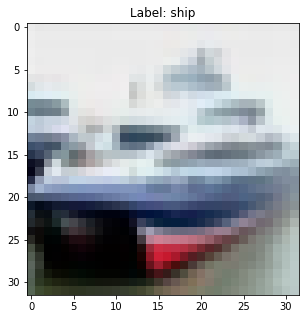

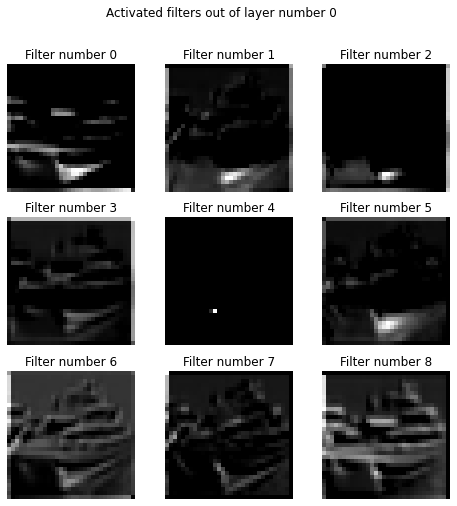

In [14]:
# your code here
y_pred_test=np.argmax(model.predict(x_test), axis=1).reshape(-1,1)
correct=np.where(y_pred_test==y_test)[0]
incorrect=np.where(y_pred_test!=y_test)[0]

# plot correct observation
np.random.seed(0)
correct_id = 1
correct_ob = x_test[correct_id]
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(correct_ob)
ax.set_title(f"Label: {cifar10dict[np.int(y_test[correct_id])]}")

# plot correct observation
activation = get_activation_maps(model, 0, correct_ob)
fig, ax = plt.subplots(3,3, figsize=(8,8))
fig.suptitle("Activated filters out of layer number 0")
for i, x in enumerate(ax.flatten()):
  x.axis("off")
  x.set_title(f"Filter number {i}")
  x.imshow(activation[i, :, :], cmap = 'gray')

plt.show()

<div class='exercise-r'>

**1.4.2**  For the same input image generate and plot a SmoothGrad saliency map to show the pixels in the image most pertinent to classification, and a Grad-CAM saliency heatmap. This is most easily done with the [tf-keras-vis](https://pypi.org/project/tf-keras-vis/) package. Take a look at the "Usage" examples; it will be straightforward to apply to our model. Feel free to pick your own [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html); however, please stick to "perceptionally uniform sequential" or "sequential" colormaps because they are far easier to interpret (`jet` is neither). Arrange the three plots in a row using subplots: Original Image, SmoothGrad saliency Map, Grad-CAM saliency heatmap. Which visualization is easier to understand in your case, and what does the network seem to be focusing on?

<a id="q143"></a> 



</div>

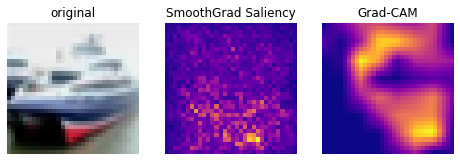

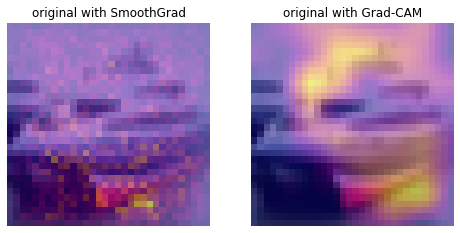

In [16]:
score = lambda x: x[:, int(y_test[correct_id])]

# Create Saliency object.
saliency = Saliency(model,)

# Generate saliency map
saliency_map = saliency(score, correct_ob,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
saliency_map = saliency_map.reshape(32, 32)

# Create Gradcam object
gradcam = Gradcam(model)

# Generate heatmap with GradCAM
cam = gradcam(score, correct_ob,
              penultimate_layer=-1)

cam = cam.reshape(32, 32)

# Plot
fig, axes = plt.subplots(1,3,figsize=(8,5))
for (i, ax), img, title in zip(enumerate(axes.flatten()),
                             [correct_ob, saliency_map, cam],
                            ["original", "SmoothGrad Saliency", "Grad-CAM"]):
    ax.imshow(img, cmap='plasma')
    #ax.imshow(correct_ob, cmap='plasma', alpha=0.5)
    ax.axis("off")
    ax.set_title(title)

fig, axes = plt.subplots(1,2,figsize=(8,5))
axes[0].imshow(correct_ob)
axes[0].imshow(saliency_map, cmap='plasma', alpha = 0.5)
axes[0].axis("off")
axes[0].set_title('original with SmoothGrad')

axes[1].imshow(correct_ob)
axes[1].imshow(cam, cmap='plasma', alpha = 0.5)
#ax.imshow(correct_ob, cmap='plasma', alpha=0.5)
axes[1].axis("off")
axes[1].set_title('original with Grad-CAM')

plt.show()

**INTERPRETATION:**

* The Grad-CAM heatmap is easier to understand in our case because it shows specific areas of attention. The SmoothGrad Saliency map also shows areas of attention but the contrast between the values of saliency of each pixel is not as distinctive.
* The NN appears to be focusing on the horizontal lines in the body of the ship.

<div class='exercise-r'>

**1.4.3**  Repeat 1.4.2, but for an image from the test set that is **incorrectly classified**, indicating both the incorrect label and what the correct label should be, and from the visualizations of network attention, hypothesize why the network arrived at its answer. (Make sure you pass a new loss to the visualizers that uses the **incorrect** class index, because we want to see what caused the network to think the image was in that category!) If you had control over what images go in the training dataset, how could you modify it to avoid this particular network failure?

</div>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


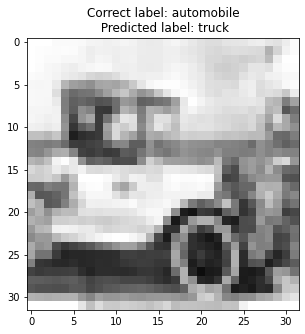

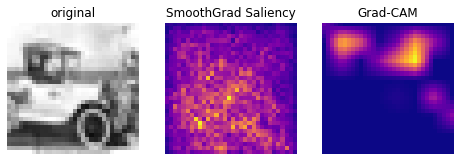

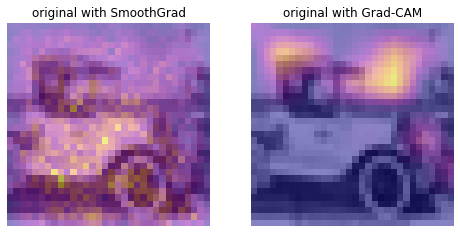

In [20]:
# plot correct observation
np.random.seed(0)
incorrect_id = 37
incorrect_ob = x_test[incorrect_id]
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(incorrect_ob)
ax.set_title(f"Correct label: {cifar10dict[np.int(y_test[incorrect_id])]}\n Predicted label: {cifar10dict[np.int(y_pred_test[incorrect_id])]}")
plt.show()

# saliency map
score = lambda x: x[:, int(y_pred_test[incorrect_id])]

# Create Saliency object.
saliency = Saliency(model)

# Generate saliency map
saliency_map = saliency(score, incorrect_ob,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
saliency_map = saliency_map.reshape(32, 32)

# Create Gradcam object
gradcam = Gradcam(model)

# Generate heatmap with GradCAM
cam = gradcam(score, incorrect_ob,
              penultimate_layer=-1)

cam = cam.reshape(32, 32)

# Plot
fig, axes = plt.subplots(1,3,figsize=(8,5))
for (i, ax), img, title in zip(enumerate(axes.flatten()),
                             [incorrect_ob, saliency_map, cam],
                            ["original", "SmoothGrad Saliency", "Grad-CAM"]):
    ax.imshow(img, cmap='plasma')
    #ax.imshow(correct_ob, cmap='plasma', alpha=0.5)
    ax.axis("off")
    ax.set_title(title)

fig, axes = plt.subplots(1,2,figsize=(8,5))
axes[0].imshow(incorrect_ob)
axes[0].imshow(saliency_map, cmap='plasma', alpha = 0.5)
axes[0].axis("off")
axes[0].set_title('original with SmoothGrad')

axes[1].imshow(incorrect_ob)
axes[1].imshow(cam, cmap='plasma', alpha = 0.5)
#ax.imshow(correct_ob, cmap='plasma', alpha=0.5)
axes[1].axis("off")
axes[1].set_title('original with Grad-CAM')
plt.show()


**INTERPRETATION:**

* From GRAD Cam, the NN focuses on the border between the car and the background and incorrectly classifies this as a truck. This particular image of an automobile have sharp lines at the top that could make it look like the top of a truck. I would include more images of automobile with top parts that don't look like a truck.

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [45 pts]: Regression with CNN 

[Return to contents](#contents)

<a id="part2intro"></a>

## Overview

[Return to contents](#contents)

**In this problem we will construct a neural network to predict how far a face is from being "upright"**. 

**Image orientation estimation**

Image orientation estimation with convolutional networks was first implemented in 2015 by Fischer, Dosovitskiy, and Brox in a paper titled ["Image Orientation Estimation with Convolutional Networks"](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf). In that paper, the authors trained a network to straighten a wide variety of images using the [Microsoft COCO dataset](https://cocodataset.org/#home). 

**The modified CelebA dataset**

In order to have a reasonable training time for a homework, we will be working on a subset of the problem where we just straighten images of faces. To do this:

- We will be using the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset of celebrity faces, where we assume that professional photographers have taken level pictures;


- The training will be supervised, with a rotated image (up to $\pm 60^\circ$) as an input, and the amount (in degrees) that the image has been rotated as a target. 

<a id="part2questions"></a>

### <div class='exercise'>PART 2: Questions</div> 

[Return to contents](#contents)


<a id="q21"></a>

**2.1** <span style='color:blue'>**Data preparation**</span>

<a id="q211"></a>

**2.1.1** **Loading CelebA and Thinking about Datasets.** Run the cells provided to automatically download the CelebA dataset. It is about 1.3GB, which can take 10-15 minutes to download. This happens only once. In the future, when you rerun the cell, it will use the dataset already stored on your machine. Once downloaded, we load the CelebA image data as a TensorFlow Dataset object. [TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from PART 1 where the entire dataset was loaded in as an array. Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`).

  - **Run the provided code**:

    - The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and test dataset `test_rot_ds`. 
  
  - **Answer this question:**
  
    - Aside from pipelining, what is an important practical reason to use TensorFlow Dataset objects over simply loading all the data into $X$ and $Y$ `numpy` arrays? 

<a id="q212"></a>

**2.1.2** **Taking a look.** In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. **HINT:** one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more information.

<a id="q213"></a>

**2.1.3** **Conceptual Question.** Dropout layers have been shown to work well for regularizing deep neural networks, and can be used with very little computational cost. For our network, is it a good idea to use dropout layers? Explain, in **3-5 sentences**, being sure to explicitly discuss how a dropout layer works, and what that would mean for our model.

<a id="q22"></a>

**2.2** <span style='color:blue'>**Building and training your CNN**</span>

<a id="q221"></a>

**2.2.1** **Compiling your model.** Construct a model with multiple Conv layers and any other layers you think would help. Be certain to print your model summary as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we have been able to do it with substantially fewer. Any working setup is acceptable as long as you construct the network yourself and do not use a pre-written implementation.

<a id="q222"></a>

**2.2.2** **Training your model.** Train your model. Please note that the `model.fit()` argument syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. However, your final model MUST be trained on all the available training data! You should achieve validation and test MSEs of less than 9, corresponding roughly to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.

<a id="q223"></a>

**2.2.3** **Saving and loading your weights.** Save your model weights to the path `model/your_model_name` where `your_model_name` is whatever filename prefix you want. Then reload your weights from that same path.
  - **NOTE:** If you don't intend to use it, you may leave your line of code commented out. Nothing should change if you run it after saving it though, since it will load the same weights and everything else about the model will still be in memory. If you close your notebook or restart your kernel in the future, run all the cells required to compile the model, but skip the cells that performs the fit and the save. After running the load weights cell, your previously trained model will be restored.
  - **Answer this question in a few sentences:** Suppose you save just the weights after training for a while. If you were to load the weights again and continue training, would it work? How will it be different than continuing from a full-model save?

<a id="q224"></a>

**2.2.4** **Evaluating your model.** Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like the image shown below. This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

![straightened face](data/straightened.png)


<a id="q23"></a>

**2.3** <span style='color:blue'>**Further Analysis**</span>

<a id="q231"></a>

**2.3.1** **Correct an image of your choosing.** Find an image or image(s) (not from the provided test/training sets), or make your own. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.] (you may use the provided `normalize_image` function) and use your network to correct it.

![Confused Chris](data/chrisprattcorrection.png)

<a id="part2solutions"></a>

## PART 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1**  <span style='color:blue'>**Data preparation**</span>

<a id="q211"></a>



</div>

<div class='exercise-r'>

**2.1.1**  **Loading CelebA and Thinking about Datasets.** Run the cells provided to automatically download the CelebA dataset. It is about 2.5GB, which can take 10-20 minutes to download. This happens only once. In the future, when you rerun the cell, it will use the dataset already stored on your machine. Once downloaded, we load the CelebA image data as a TensorFlow Dataset object. [TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from PART 1 where the entire dataset was loaded in as an array. Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`).

  - **Run the provided code**:

    - The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and test dataset `test_rot_ds`. 
  
  - **Answer this question:**
  
    - Aside from pipelining, what is an important practical reason to use TensorFlow Dataset objects over simply loading all the data into $X$ and $Y$ `numpy` arrays? 

<a id="q212"></a>





</div>

In [ ]:
# Run this cell to define our download_celeb function

def download_celeb(
    url, 
    filename,
    filepath,
    dirname,
    dirpath,
    chunk_size=1204,
    overwrite=False,
):
    """Downloads and extracts CelebA dataset from CS109B S3 bucket"""
    
    # Do not download if data already exists and overwrite==False
    if not overwrite and os.path.isdir(os.path.join(dirpath, "2.0.1")):
        print(
            "Congratulations...the CelebA dataset already exists "
            "locally!\nNo new downloads are required :o)\n"
        )
    # Download and extract CelebA if it doesn't already exist
    else:
        print("Downloading CelebA dataset to {}\n".format(filepath))

        with requests.get(url, stream=True) as r:
            chunk_size = 1024
            length = int(r.headers['content-length'])
            print(
                "...downloading a {:.2f} GB file."
                "This is going to take a while!".format(length/1e9)
            )
            time.sleep(0.5)
            with open(filepath, 'wb') as f:
                for chunk in tqdm.tqdm(
                    r.iter_content(chunk_size=chunk_size),
                    total=int(length/chunk_size),
                    unit="KB"
                ):
                    f.write(chunk)

        print("...{} download complete :o)".format(filename))

        if not os.path.isdir(dirpath):
            os.makedirs(dirpath)

        print(
            "...extracting {}. This will take a while too :o(\n"
            "".format(filename)
        )

        with zipfile.ZipFile(filepath, 'r') as zipobj:
            zipobj.extractall(dirpath)

        print(
            "The CelebA dataset has been extracted to:"
            "\n\n\t{}\n".format(dirpath)
        )

In [ ]:
%%time
# Download the CelebA dataset from the CS109B S3 bucket
url = "https://cs109b-prod-course-data.s3.amazonaws.com/CelebA/2.0.1.zip"
filename = "2.0.1.zip"
dirname = "data/celeb_a"
dirpath = os.path.join(working_dir, dirname)
filepath = os.path.join(working_dir, filename)

# Running on JupyterHub with data
if os.path.isdir('/home/course_data/celeb_a/2.0.1/'):
    data_dir = '/home/course_data'
# Running anywhere else
else:
    data_dir = os.path.join(working_dir, "data")
    download_celeb(url, filename, filepath, dirname, dirpath)


...downloading a 1.31 GB file.This is going to take a while!


1282632KB [00:33, 38219.41KB/s]                             


...2.0.1.zip download complete :o)
...extracting 2.0.1.zip. This will take a while too :o(

The CelebA dataset has been extracted to:

	/home/u_51532732/data/celeb_a

CPU times: user 15.7 s, sys: 3.9 s, total: 19.6 s
Wall time: 1min 5s


In [ ]:
# This command will use the celeb_a dataset that you downloaded,
# and load it into train and test "tensorflow.Datasets"

train_celeb, test_celeb = tfds.load(
    "celeb_a",
    split=["train", "test"],
    shuffle_files=False,
    data_dir = data_dir,
    download=False,
)

In [ ]:
# You may use the following two functions
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def rot_resize(img, deg):
    rotimg = ndimage.rotate(img, deg, reshape=False, order=3)
    rotimg = np.clip(rotimg, 0., 1.)
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

################################################################
# Don't manually invoke these functions; they are for Dataset 
# pipelining that is already done for you.
################################################################
def tf_rot_resize(img, deg):
    """Dataset pipe that rotates an image and resizes it to 140x120"""
    rotimg = tfa.image.rotate(img, deg/180.*np.pi, interpolation="BILINEAR")
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

def tf_random_rotate_helper(image):
    """Dataset pipe that normalizes image to [0.,1.] and rotates by a random
    amount of degrees in [-60.,60.], returning an (input,target) pair consisting
    of the rotated and resized image and the degrees it has been rotated by."""
    image = normalize_image(image)
    deg = tf.random.uniform([],-60.,60.)
    return (tf_rot_resize(image,deg), deg)  # (data, label)

def tf_random_rotate_image(element):
    """Given an element drawn from the CelebA dataset, this returns a rotated
    image and the amount it has been rotated by, in degrees."""
    image = element['image']
    image, label = tf_random_rotate_helper(image)
    image.set_shape((140,120,3))
    return image, label
################################################################

In [ ]:
# Pipeline for creating randomly rotated images with their target labels being 
# the amount they were rotated, in degrees.
train_rot_ds = train_celeb.map(tf_random_rotate_image)
test_rot_ds = test_celeb.map(tf_random_rotate_image)

**INTERPRETATION:**

* The advantage is related to memory. Using tensorflow dataset allows us to read in the data batch by batch, so that we don't have to store the entire dataset in memory. This is especially convenient for large dataset. 

<div class='exercise-r'>

**2.1.2**  **Taking a look.** In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. **HINT:** one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more information.

<a id="q213"></a>



</div>

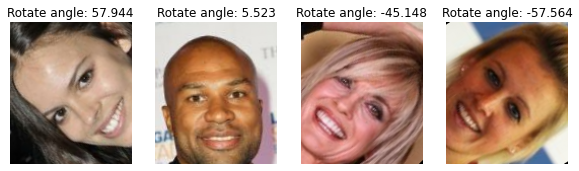

In [ ]:
# your code here
subset = train_rot_ds.take(4)
fig, ax = plt.subplots(1, 4, figsize=(10,6))
for ax, (img, label) in zip(ax.ravel(), subset.as_numpy_iterator()):
    # break when no more axes left
    if ax is None:
        break
    ax.imshow(img)
    ax.set_title(f"Rotate angle: {label:.3f}")
    ax.axis('off')

<div class='exercise-r'>

**2.1.3**  **Conceptual Question.** Dropout layers have been shown to work well for regularizing deep neural networks, and can be used with very little computational cost. For our network, is it a good idea to use dropout layers? Explain, in **3-5 sentences**, being sure to explicitly discuss how a dropout layer works, and what that would mean for our model.

<a id="q22"></a>



</div>

**INTERPRETATION:**

**Dropout in a FCNN:**
* Dropout means that for a given layer a random portion of neurons and their respective weights are left out. 

* The pro of dropout in this case is that, in case our neural network is overfitting, dropout reduces overfitting in our model. On the other hand, a con is that, if our model is relatively small with already relatively few layers, then we would be just drastically diminishing our netwrok capability with no specific reward for it.

**Dropout in a CNN:**
* Droput in CNN does NOT have the same effect as in a FCNN. The basic idea is that in a FCNN, "dropping" a neuron prevents its weights from being updated, but in CNNs dropout is "dropping" elements from the feature map, not the filters themselves. 
* Given this, gradients can still flow back to the filter from the other elements in the feature map, potentially causing the weights to be updated.

**Final remarks:**
* Despite the fact that weights could still be updated, it is possible to get better results when using dropout on convolutional layers. However, the effect of dropout on convolutional layers seems to amount to multiplying Bernoulli noise into the feature maps of the network. 
* Basically, with dropout in a CNN, we are injecting noise into the system, and we are doing that without more underlying theory; theory which is present in the case of fully-connected layers. Meaning, it can work and can help against overfitting, but it doesn’t appear that there is a good reason it should provide good results.

<div class='exercise-r'>

**2.2**  <span style='color:blue'>**Building and training your CNN**</span>

<a id="q221"></a>



</div>

<div class='exercise-r'>

**2.2.1**  **Compiling your model.** Construct a model with multiple Conv layers and any other layers you think would help. Be certain to print your model summary as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we have been able to do it with substantially fewer. Any working setup is acceptable as long as you construct the network yourself and do not use a pre-written implementation.

<a id="q222"></a>



</div>

In [ ]:

model = Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(140, 120, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.summary()


Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_330 (Conv2D)         (None, 140, 120, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 140, 120, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_331 (Conv2D)         (None, 140, 120, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 140, 120, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_165 (MaxPooli  (None, 70, 60, 32)       0         
 ng2D)                                                           
                                                     

<div class='exercise-r'>

**2.2.2**  **Training your model.** Train your model. Please note that the `model.fit()` argument syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. However, your final model MUST be trained on all the available training data! You should achieve validation and test MSEs of less than 9, corresponding roughly to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.

<a id="q223"></a>



</div>

In [ ]:
# your code here
# early stop when val loss reach 8.5
class EarlyStoppingByLossVal(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', value=8, verbose=0):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_8 = [EarlyStoppingByLossVal(monitor='val_loss', value=8.5, verbose=1)]

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              loss= 'mse', metrics = [])

BATCH_SIZE = 128
history = model.fit(train_rot_ds\
                    .shuffle(buffer_size=1000, reshuffle_each_iteration=True)
                    .batch(BATCH_SIZE).prefetch(AUTOTUNE), 
                    epochs=10,
                    callbacks=callbacks_8,
                    validation_data=test_rot_ds
                    .shuffle(buffer_size=1000, reshuffle_each_iteration=True) 
                    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

Epoch 1/10
1272/1272 [==============================] - 576s 450ms/step - loss: 29.9252 - val_loss: 9.7514
Epoch 2/10
1272/1272 [==============================] - 568s 444ms/step - loss: 25.5178 - val_loss: 7.9312


<div class='exercise-r'>

**2.2.3**  **Saving and loading your weights.** Save your model weights to the path `model/your_model_name` where `your_model_name` is whatever filename prefix you want. Then reload your weights from that same path.
  - **NOTE:** If you don't intend to use it, you may leave your line of code commented out. Nothing should change if you run it after saving it though, since it will load the same weights and everything else about the model will still be in memory. If you close your notebook or restart your kernel in the future, run all the cells required to compile the model, but skip the cells that performs the fit and the save. After running the load weights cell, your previously trained model will be restored.
  - **Answer this question in a few sentences:** Suppose you save just the weights after training for a while. If you were to load the weights again and continue training, would it work? How will it be different than continuing from a full-model save?

<a id="q224"></a>



</div>

In [ ]:
# # Save the weights
model.save_weights('model/model_weights.ckpt')

# # Restore the weights
# model.load_weights('model/model_weights.ckpt')

# Save the model
model.save('model/my_model_p2.h5')

# Load the model
# model = keras.models.load_model('my_model_p2.h5')

#https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 

**INTERPRETATION:**

* **save_weights:** it saves only the weights, and you can apply them on a different architecture if you wish to
* **save:** it saves the model, the weights, and the state of the optimizer. 

**Questions: ..if you save ONLY the weights:**
* **Woud it work, if you only load the weights?** Yes, you can use it with the same or another architecture. If you want to use the same, it will have not be saved with save_weights. So you need to save it separately in a json file.
* **Will it be different? Yes.** Saving the state of the optimizer can be important if you are using an optimizer like Adam, which combines RMS/Adagrad with Momentum. Being that Momentum depends on the average direction up to that step,  if you don't save that, then if you continue training you are going to be training from another step and the outcome will likely be different than continuing from a full-model save.

<div class='exercise-r'>

**2.2.4**  **Evaluating your model.** Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like the image shown below. This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

![straightened face](data/straightened.png)


<a id="q23"></a>



</div>

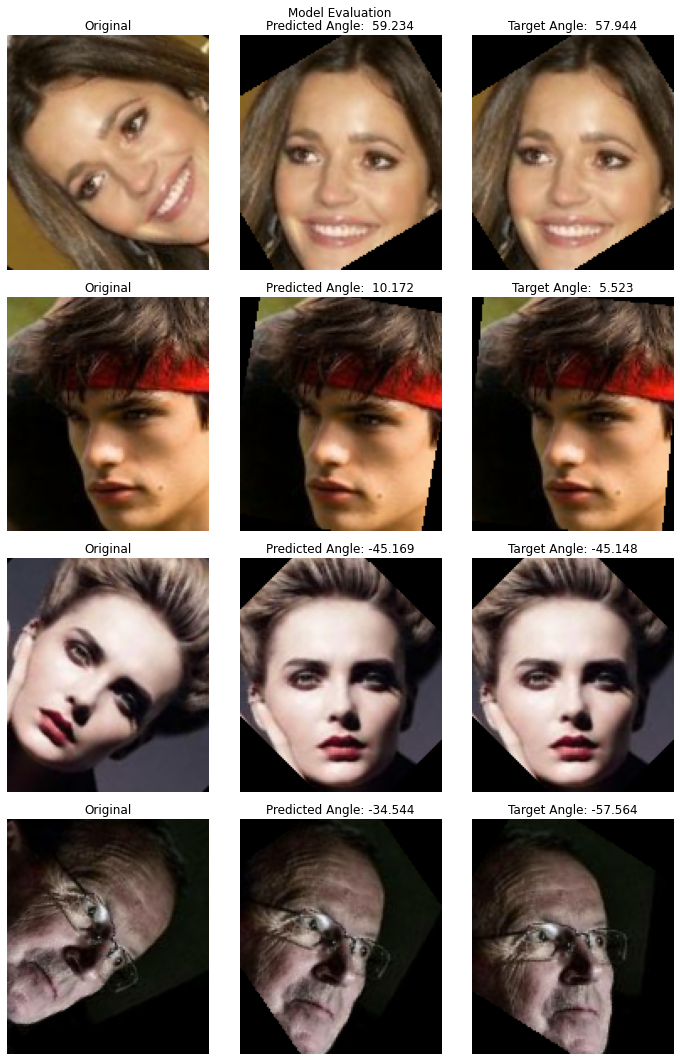

In [ ]:
# your code here
test_iterator = test_rot_ds.as_numpy_iterator()

fig, axes = plt.subplots(4, 3, figsize = (10,15))
fig.suptitle("Model Evaluation")
for row in range(0,4): #, (img, label) in zip(range(0,4), subset.as_numpy_iterator()):
  
  test_img, test_label = next(test_iterator)
  pred_angle = model.predict(np.expand_dims(test_img, 0))

  #original image
  axes[row][0].set_title('Original')
  axes[row][0].imshow(test_img)
  axes[row][0].axis('off')

  #predicted straightened image
  axes[row][1].set_title(f'Predicted Angle: {pred_angle[0][0]: .3f}')
  axes[row][1].imshow(rot_resize(test_img, -pred_angle[0][0]))
  axes[row][1].axis('off')

  #target straightened image
  axes[row][2].set_title(f'Target Angle: {test_label: .3f}')
  axes[row][2].imshow(rot_resize(test_img, -test_label))
  axes[row][2].axis('off')
plt.tight_layout()
plt.show()


<div class='exercise-r'>

**2.3**  <span style='color:blue'>**Further Analysis**</span>

<a id="q231"></a>



</div>

<div class='exercise-r'>

**2.3.1**  **Correct an image of your choosing.** Find an image or image(s) (not from the provided test/training sets), or make your own. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.] (you may use the provided `normalize_image` function) and use your network to correct it.

![Confused Chris](data/chrisprattcorrection.png)

</div>

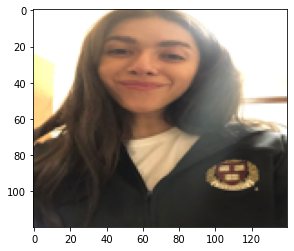

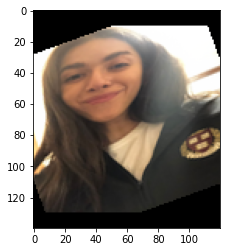

In [ ]:
# your code here
img = Image.open('homework_image2.jpeg')
img = img.resize(size=(140, 120))
np_img = normalize_image(np.asarray(img))
plt.imshow(np_img)
plt.show()

# rotation:
rot_angle = 20
img_rot = rot_resize(np_img, rot_angle)
plt.imshow(img_rot)
plt.show()

Predicted rotation angle: 26.224


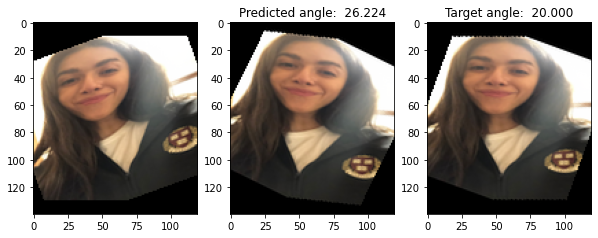

In [ ]:
# predict rotation angle
predict = model.predict(np.expand_dims(img_rot, 0))
print(f"Predicted rotation angle: {predict[0][0]:.3f}")

# plot
fig, ax = plt.subplots(1, 3, figsize=(10,15))
ax[0].imshow(img_rot)
ax[1].set_title(f"Predicted angle: {predict[0][0]: .3f}")
ax[1].imshow(rot_resize(img_rot, -predict[0][0]))
ax[2].set_title(f"Target angle: {rot_angle: .3f}")
ax[2].imshow(rot_resize(img_rot, -rot_angle))